<a href="https://colab.research.google.com/github/LeonardoSer/Univ/blob/main/NetOpt/jupyter_notebooks/Fixed%20Charge-gurobi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fixed Charge Network Flow Problem

**Given:**

* A directed graph $G=(N,A)$  with a source node $s$
* A demand vector $b \in \mathbb{Z}^{|N|}$ such that $b_s > 0$,\
$$b_i \le 0, \forall i \in N, i \not =\{s\}$$ and $$\sum_{i \in N} b_i=0$$ 
* A capacity vector $u \in \mathbb{Z}^{|A|}$ 
* A cost vector $c \in \mathbb{Z}^{|A|}$ representing the arcs activation cost

**Find**

A *feasible flow vector* $x$ (see definition of feasible flow in Module I) $0 \le x \le u$ that minimizes the sum of the costs of activated arcs


## Example

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import gurobipy as gb

%matplotlib inline

In [ ]:
 G = nx.DiGraph()

In [ ]:
G.add_nodes_from(['s','a','b','c','d','t'])

In [ ]:
G.add_edge ('s', 'a', capacity = 10, activation =  100)
G.add_edge ('s', 'b', capacity = 30, activation = 1)
G.add_edge ('a', 'b', capacity = 55, activation =  5)
G.add_edge ('b', 'c', capacity = 28, activation =  150)
G.add_edge ('a', 'c', capacity = 62, activation =  5)
G.add_edge ('a', 'd', capacity = 34, activation =  130)
G.add_edge ('b', 'd', capacity = 73, activation =  100)
G.add_edge ('c', 'd', capacity = 45, activation =  10)
G.add_edge ('c', 't', capacity = 32, activation =  3)
G.add_edge ('d', 't', capacity = 12, activation =  200)

print (G.edges(data=True))

[('s', 'a', {'capacity': 10, 'activation': 100}), ('s', 'b', {'capacity': 30, 'activation': 1}), ('a', 'b', {'capacity': 55, 'activation': 5}), ('a', 'c', {'capacity': 62, 'activation': 5}), ('a', 'd', {'capacity': 34, 'activation': 130}), ('b', 'c', {'capacity': 28, 'activation': 150}), ('b', 'd', {'capacity': 73, 'activation': 100}), ('c', 'd', {'capacity': 45, 'activation': 10}), ('c', 't', {'capacity': 32, 'activation': 3}), ('d', 't', {'capacity': 12, 'activation': 200})]


In [ ]:
demand_b = {'s':40, 'a':0,'b':0,'c':0,'d':0,'t':-40}

In [ ]:
pos = nx.shell_layout(G)

edge_lab = {i:[G[i[0]][i[1]]['capacity'], \
               G[i[0]][i[1]]['activation']] for i in G.edges()}

node_lab = {i:demand_b[i] for i in G.nodes()}

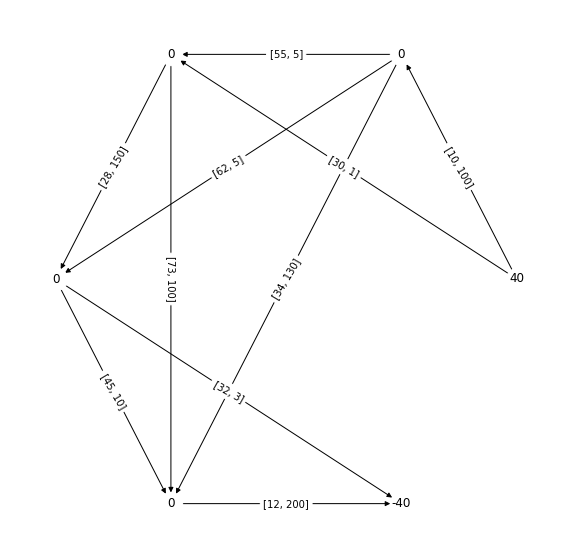

In [ ]:
plt.figure(figsize=(10,10))

nx.draw_networkx_edge_labels (G, pos, edge_labels=edge_lab)
nx.draw_networkx_labels (G,pos, labels=node_lab)

nx.draw(G, pos, with_labels=False, node_color ='w', node_size=500)

## Variables

In [ ]:
fixedcharge = gb.Model('Fixed Charge Network Problem')

x = fixedcharge.addVars(G.edges(),
                        vtype=gb.GRB.CONTINUOUS, name='x')

In [ ]:
y = fixedcharge.addVars(G.edges(), 
                        vtype=gb.GRB.BINARY, name='y')

## Objective function

In [ ]:
fixedcharge.setObjective(y.prod(nx.get_edge_attributes(G, 'activation')), \
                         gb.GRB.MINIMIZE)

In [ ]:
fixedcharge.write('fixedcharge.lp')

## Balance constraints

In [ ]:
fixedcharge.addConstrs((x.sum(i, G.out_edges(i)) - (x.sum(G.in_edges(i), i)) == 
                        demand_b[i] for i in G.nodes()), name='Balance')

fixedcharge.update()

fixedcharge.write('fixedcharge.lp')


## Variable upper bounds

In [ ]:
fixedcharge.addConstrs((G[i][j]['capacity'] * y[(i,j)] >= x[(i,j)]\
                       for (i,j) in G.edges()), name='VUB')

fixedcharge.update()

fixedcharge.write('fixedcharge.lp')



## Problem solution

In [ ]:
fixedcharge.optimize()

Optimize a model with 16 rows, 20 columns and 40 nonzeros
Variable types: 10 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [1e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+01, 4e+01]
Presolve removed 12 rows and 14 columns
Presolve time: 0.00s
Presolved: 4 rows, 6 columns, 9 nonzeros
Variable types: 3 continuous, 3 integer (3 binary)

Root relaxation: objective 5.590000e+02, 3 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     559.0000000  559.00000  0.00%     -    0s

Explored 0 nodes (3 simplex iterations) in 0.01 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 559 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.590000000000e+02, best bound 5.590000000000e+02, gap 0.0000%


In [ ]:
print('Obj: %g' % fixedcharge.objVal)

print ()

for v in fixedcharge.getVars():
    if v.x > 1E-3:
        print ('%s=%g' % (v.varName, v.x), end = ' ')
    
    

Obj: 559

x[s,a]=10 x[s,b]=30 x[a,b]=10 x[b,c]=28 x[b,d]=12 x[c,t]=28 x[d,t]=12 y[s,a]=1 y[s,b]=1 y[a,b]=1 y[b,c]=1 y[b,d]=1 y[c,t]=1 y[d,t]=1 

## Solution representation: activated arcs are in red

_If you experience problem with the drawing functions remove this cell from your notebook_



In [ ]:
pos = nx.shell_layout(G)

edge_lab = {i: int(round(x[i].x)) for i in G.edges() if x[i].x > 1E-3}

edge_lab

{('s', 'a'): 10,
 ('s', 'b'): 30,
 ('a', 'b'): 10,
 ('b', 'c'): 28,
 ('b', 'd'): 12,
 ('c', 't'): 28,
 ('d', 't'): 12}

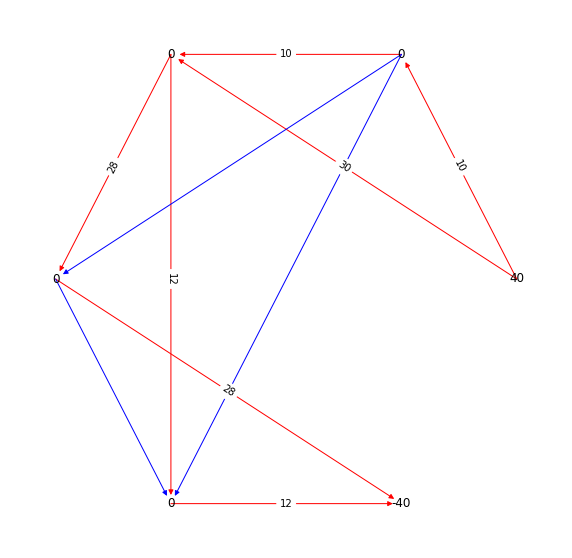

In [ ]:
plt.figure(figsize=(10,10))

activated_edge = [i for i in G.edges() if x[i].x > 1E-3]
not_activated_edge = [i for i in G.edges() if x[i].x <= 1E-3]

nx.draw_networkx_edges (G, pos, edgelist=activated_edge, edge_color='r')
nx.draw_networkx_edges (G, pos, edgelist=not_activated_edge, edge_color='b')
nx.draw_networkx_edge_labels (G, pos, edge_labels=edge_lab)

nx.draw_networkx_labels (G,pos, labels=node_lab)
#nx.draw_networkx_nodes(G,pos,with_labels=True, node_color ='b')
nx.draw(G, pos, with_labels=True,  alpha=0.0, node_color ='w', node_size=500)